In [2]:
import io
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

device = "cpu"

In [4]:

df = pd.read_csv("dataset.csv")

df.columns = ['Datatime', 'temp_day', 'wind', 'pressure_day', 'temp_even', 'pressure_even']  
df = df.drop(columns = ['wind', 'pressure_day', 'temp_even', 'pressure_even'])

nan_value = float("NaN")                             # 3  ( null / None / Nan ) 
df.replace(" ", nan_value, inplace=True)
df = df.dropna()

df[['temp_day']] = df[['temp_day']].astype(int)  # 4
df_save = df
print(df)

        Datatime  temp_day
0     2022-09-02        21
1     2022-09-03        17
2     2022-09-04        13
3     2022-09-05        14
4     2022-09-06        10
...          ...       ...
4839  2009-01-26        -6
4840  2009-01-27        -4
4841  2009-01-28        -5
4842  2009-01-29        -7
4843  2009-01-30        -9

[4835 rows x 2 columns]


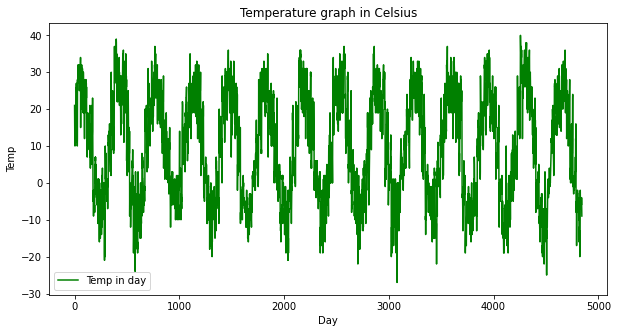

In [5]:
import matplotlib.pyplot as plt
fig1 = plt.figure(figsize=(10, 5))
plt.title("Temperature graph in Celsius")    # Temperature graph in Celsius
plt.xlabel("Day")
plt.ylabel("Temp")
plt.plot(df['temp_day'], color="green")
plt.legend(["Temp in day"])
plt.show()

In [6]:
import plotly.graph_objs as go
from plotly.offline import iplot

def plot_dataset(df: pd.DataFrame, title: str) -> None:
    """the function takes a DataFrame and shows a graph"""
    data = []
    
    value = go.Scatter(
        x=df.index,
        y=df.value,
        mode="lines",
        name="values",
        marker=dict(),
        text=df.index,
        line=dict(color="rgba(0,0,0, 0.3)"),
    )
    data.append(value)

    layout = dict(
        title=title,
        xaxis=dict(title="Date", ticklen=5, zeroline=False),
        yaxis=dict(title="Value", ticklen=5, zeroline=False),
    )

    fig = dict(data=data, layout=layout)
    iplot(fig)

In [7]:
df = df.set_index(['Datatime'])
df = df.rename(columns={'temp_day': 'value'})

df.index = pd.to_datetime(df.index)
if not df.index.is_monotonic_increasing:
    df = df.sort_index()
    
plot_dataset(df, title='Samara region: estimated temperature value in Degrees Celsius (°C)')

In [8]:
def generate_time_lags(df: pd.DataFrame, n_lags: int):
    """the function of generating observations with a time delay"""
    df_n = df.copy()
    for n in range(1, n_lags + 1):
        df_n[f"lag{n}"] = df_n["value"].shift(n) #shift метод для сдвига значенией в столбце
    df_n = df_n.iloc[n_lags:]
    return df_n

input_dim = 100

df_timelags = generate_time_lags(df, input_dim)
print(df_timelags)

            value  lag1  lag2  lag3  lag4  lag5  lag6  lag7  lag8  lag9  ...  \
Datatime                                                                 ...   
2009-04-14      9   9.0   7.0   6.0   2.0   0.0   1.0   4.0   4.0   2.0  ...   
2009-04-15     12   9.0   9.0   7.0   6.0   2.0   0.0   1.0   4.0   4.0  ...   
2009-04-16     14  12.0   9.0   9.0   7.0   6.0   2.0   0.0   1.0   4.0  ...   
2009-04-17      3  14.0  12.0   9.0   9.0   7.0   6.0   2.0   0.0   1.0  ...   
2009-04-18     16   3.0  14.0  12.0   9.0   9.0   7.0   6.0   2.0   0.0  ...   
...           ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
2022-09-25     11  17.0  24.0  26.0  17.0  16.0  27.0  21.0  20.0  18.0  ...   
2022-09-26     11  11.0  17.0  24.0  26.0  17.0  16.0  27.0  21.0  20.0  ...   
2022-09-27     13  11.0  11.0  17.0  24.0  26.0  17.0  16.0  27.0  21.0  ...   
2022-09-28     10  13.0  11.0  11.0  17.0  24.0  26.0  17.0  16.0  27.0  ...   
2022-09-29     12  10.0  13.0  11.0  11.

<ipython-input-8-a0fb148c7444>:5: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



In [9]:
import sklearn
from sklearn.model_selection import train_test_split

def feature_label_split(df: pd.DataFrame, target_col: str):
    """separtion into x and y"""
    y = df[[target_col]]
    X = df.drop(columns=[target_col])
    return X, y

def train_val_test_split(df: pd.DataFrame, target_col: str, test_ratio: float) -> pd.DataFrame:
    """separtion into test, val, test"""

    val_ratio = test_ratio / (1 - test_ratio)

    X, y = feature_label_split(df, target_col)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio, shuffle=False)  

    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(df_timelags, 'value', 0.1)

print(f'Процент обучащей выборки: {X_train["lag1"].count() / df_timelags["lag1"].count()*100}%')
print(f'Процент тестовой выборки: {X_test["lag1"].count() / df_timelags["lag1"].count()*100}%')
print(f'Процент валидационной выборки: {X_val["lag1"].count() / df_timelags["lag1"].count()*100}%')

#print(X_test)
#print(y_test)


Процент обучащей выборки: 79.97888067581837%
Процент тестовой выборки: 10.010559662090813%
Процент валидационной выборки: 10.010559662090813%


In [10]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler

def get_scaler(scaler: str) -> sklearn.preprocessing:
    scalers = {
        "minmax": MinMaxScaler,
        "standard": StandardScaler,
        "maxabs": MaxAbsScaler,
        "robust": RobustScaler,
    }
    return scalers.get(scaler.lower())()

In [11]:
scaler = get_scaler('minmax') #маштабирование данных

X_train_arr = scaler.fit_transform(X_train)  #стандартизация данных
X_val_arr = scaler.transform(X_val)
X_test_arr = scaler.transform(X_test)

y_train_arr = scaler.fit_transform(y_train)
y_val_arr = scaler.transform(y_val)
y_test_arr = scaler.transform(y_test)   

print(X_train_arr)

[[0.53731343 0.50746269 0.49253731 ... 0.19402985 0.28358209 0.25373134]
 [0.53731343 0.53731343 0.50746269 ... 0.1641791  0.19402985 0.28358209]
 [0.58208955 0.53731343 0.53731343 ... 0.2238806  0.1641791  0.19402985]
 ...
 [0.3880597  0.40298507 0.34328358 ... 0.71641791 0.71641791 0.73134328]
 [0.41791045 0.3880597  0.40298507 ... 0.49253731 0.71641791 0.71641791]
 [0.41791045 0.41791045 0.3880597  ... 0.47761194 0.49253731 0.71641791]]


In [12]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 64

train_features = torch.Tensor(X_train_arr)  #Преобразование массивов NumPy в tensor torch 
train_targets = torch.Tensor(y_train_arr)
val_features = torch.Tensor(X_val_arr)
val_targets = torch.Tensor(y_val_arr)
test_features = torch.Tensor(X_test_arr)
test_targets = torch.Tensor(y_test_arr)

train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

In [13]:
class RNNModel(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, layer_dim: int, output_dim: int, dropout_prob: float) -> None:
        """The __init__ method that initiates an RNN instance.

        Args:
            input_dim (int): The number of nodes in the input layer
            hidden_dim (int): The number of nodes in each layer
            layer_dim (int): The number of layers in the network
            output_dim (int): The number of nodes in the output layer
            dropout_prob (float): The probability of nodes being dropped out

        """
        super(RNNModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # RNN layers
        self.rnn = nn.RNN(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """The forward method takes input tensor x and does forward propagation

        Args:
            x (torch.Tensor): The input tensor of the shape (batch size, sequence length, input_dim)

        Returns:
            torch.Tensor: The output tensor of the shape (batch size, output_dim)

        """
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, h0 = self.rnn(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        return out

In [14]:
class Optimization:
    """Optimization is a helper class that allows training, validation, prediction.

    Optimization is a helper class that takes model, loss function, optimizer function
    learning scheduler (optional), early stopping (optional) as inputs. In return, it
    provides a framework to train and validate the models, and to predict future values
    based on the models.

    Attributes:
        model (RNNModel, LSTMModel, GRUModel): Model class created for the type of RNN
        loss_fn (torch.nn.modules.Loss): Loss function to calculate the losses
        optimizer (torch.optim.Optimizer): Optimizer function to optimize the loss function
        train_losses (list[float]): The loss values from the training
        val_losses (list[float]): The loss values from the validation
        last_epoch (int): The number of epochs that the models is trained
    """
    def __init__(self, model, loss_fn, optimizer):
        """
        Args:
            model (RNNModel, LSTMModel, GRUModel): Model class created for the type of RNN
            loss_fn (torch.nn.modules.Loss): Loss function to calculate the losses
            optimizer (torch.optim.Optimizer): Optimizer function to optimize the loss function
        """
        self.model = model.to(device)
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
        
    def train_step(self, x, y):
        """The method train_step completes one step of training.

        Given the features (x) and the target values (y) tensors, the method completes
        one step of the training. First, it activates the train mode to enable back prop.
        After generating predicted values (yhat) by doing forward propagation, it calculates
        the losses by using the loss function. Then, it computes the gradients by doing
        back propagation and updates the weights by calling step() function.

        Args:
            x (torch.Tensor): Tensor for features to train one step
            y (torch.Tensor): Tensor for target values to calculate losses

        """
        # Sets model to train mode
        self.model.train()

        # Makes predictions
        yhat = self.model(x)

        # Computes loss
        loss = self.loss_fn(y, yhat)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()

    def train(self, train_loader, val_loader, batch_size=64, n_epochs=50, n_features=1):
        """The method train performs the model training

        The method takes DataLoaders for training and validation datasets, batch size for
        mini-batch training, number of epochs to train, and number of features as inputs.
        Then, it carries out the training by iteratively calling the method train_step for
        n_epochs times. If early stopping is enabled, then it  checks the stopping condition
        to decide whether the training needs to halt before n_epochs steps. Finally, it saves
        the model in a designated file path.

        Args:
            train_loader (torch.utils.data.DataLoader): DataLoader that stores training data
            val_loader (torch.utils.data.DataLoader): DataLoader that stores validation data
            batch_size (int): Batch size for mini-batch training
            n_epochs (int): Number of epochs, i.e., train steps, to train
            n_features (int): Number of feature columns

        """
        model_path = f'{self.model}_{datetime.now().strftime("%Y-%m-%d %H:%M:%S")}'

        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.view([batch_size, -1, n_features]).to(device)
                y_batch = y_batch.to(device)
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, -1, n_features]).to(device)
                    y_val = y_val.to(device)
                    self.model.eval()
                    yhat = self.model(x_val)
                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)

            if (epoch <= 10) | (epoch % 50 == 0):
                print(
                    f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}"
                )

        torch.save(self.model.state_dict(), model_path)

    def evaluate(self, test_loader, batch_size=1, n_features=1):
        """The method evaluate performs the model evaluation

        The method takes DataLoaders for the test dataset, batch size for mini-batch testing,
        and number of features as inputs. Similar to the model validation, it iteratively
        predicts the target values and calculates losses. Then, it returns two lists that
        hold the predictions and the actual values.

        Note:
            This method assumes that the prediction from the previous step is available at
            the time of the prediction, and only does one-step prediction into the future.

        Args:
            test_loader (torch.utils.data.DataLoader): DataLoader that stores test data
            batch_size (int): Batch size for mini-batch training
            n_features (int): Number of feature columns

        Returns:
            list[float]: The values predicted by the model
            list[float]: The actual values in the test set.

        """
        with torch.no_grad():
            predictions = []
            values = []
            for x_test, y_test in test_loader:
                x_test = x_test.view([batch_size, -1, n_features]).to(device)
                y_test = y_test.to(device)
                self.model.eval()
                yhat = self.model(x_test)
                predictions.append(yhat.to(device).detach().numpy())
                values.append(y_test.to(device).detach().numpy())

        return predictions, values

    def plot_losses(self):
        """The method plots the calculated loss values for training and validation
        """
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()

[1/100] Training loss: 0.0484	 Validation loss: 0.0078
[2/100] Training loss: 0.0110	 Validation loss: 0.0071
[3/100] Training loss: 0.0092	 Validation loss: 0.0069
[4/100] Training loss: 0.0088	 Validation loss: 0.0066
[5/100] Training loss: 0.0083	 Validation loss: 0.0064
[6/100] Training loss: 0.0094	 Validation loss: 0.0065
[7/100] Training loss: 0.0081	 Validation loss: 0.0063
[8/100] Training loss: 0.0074	 Validation loss: 0.0059
[9/100] Training loss: 0.0070	 Validation loss: 0.0060
[10/100] Training loss: 0.0069	 Validation loss: 0.0070
[50/100] Training loss: 0.0070	 Validation loss: 0.0044
[100/100] Training loss: 0.0050	 Validation loss: 0.0040


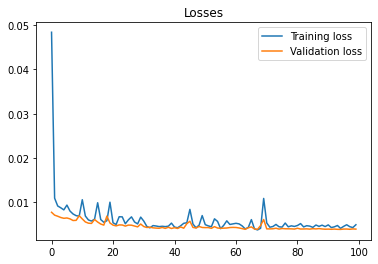

In [99]:
import torch.optim as optim

input_dim = len(X_train.columns)
output_dim = 1
hidden_dim = 64
layer_dim = 3
batch_size = 64
dropout = 0.2
n_epochs = 100
learning_rate = 1e-3
weight_decay = 1e-6

model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

model = RNNModel(**model_params)

loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()

predictions, values = opt.evaluate(
    test_loader_one,
    batch_size=1,
    n_features=input_dim
)

In [100]:
def inverse_transform( scaler: sklearn.preprocessing._data.MinMaxScaler, df: pd.DataFrame, columns: list) -> pd.DataFrame:
    """function inverse_transform DataFrame"""
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
    return df


def format_predictions(predictions: list, values: list, df_test: pd.DataFrame, scaler: sklearn.preprocessing._data.MinMaxScaler)-> pd.DataFrame:
    """DataFrame creation function with predictions"""
    vals = np.concatenate(values, axis=0).ravel()
    preds = np.concatenate(predictions, axis=0).ravel()
    df_result = pd.DataFrame(data={"value": vals, "prediction": preds}, index=df_test.head(len(vals)).index)
    df_result = df_result.sort_index()
    df_result = inverse_transform(scaler, df_result, [["value", "prediction"]])
    return df_result

df_result = format_predictions(predictions, values, X_test, scaler)
df_result

,value,prediction
Datatime,,
2021-05-23,35.000000,27.212753
2021-05-24,24.000002,28.213396
2021-05-25,24.000002,26.221796
2021-05-26,22.999998,25.055552
2021-05-27,24.000002,24.260410
...,...,...
2022-09-25,11.000000,18.101889
2022-09-26,11.000000,13.401238
2022-09-27,12.999998,11.840582


In [101]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calculate_metrics(df: pd.DataFrame) -> dict:
    """Function calculate metrics value and predictions"""
    result_metrics = {'mae' : mean_absolute_error(df.value, df.prediction),
                      'rmse' : mean_squared_error(df.value, df.prediction) ** 0.5,
                      'r2' : r2_score(df.value, df.prediction)}
    
    print("Mean Absolute Error:       ", result_metrics["mae"])   #средняя абсолютная ошибка
    print("Root Mean Squared Error:   ", result_metrics["rmse"])  #средняя квадратичная ошибка
    print("R^2 Score:                 ", result_metrics["r2"])    # КФ
    return result_metrics

result_metrics = calculate_metrics(df_result)

Mean Absolute Error:        3.3928711
Root Mean Squared Error:    4.107822835799687
R^2 Score:                  0.9119331392176245


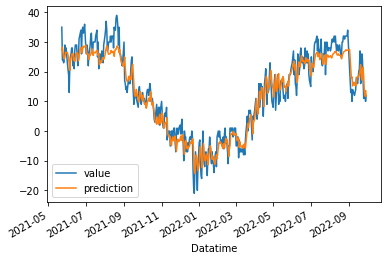

In [102]:
df_result.plot()


In [104]:
def comparison(df_result: pd.DataFrame, month: int, year: int) -> None:
    """function comparison of a predicate and a DataSet"""

    if (month < 10): month = "0" + str(month)
    data1 = str(str(year) + "-" + month + "-" + "01")
    data2 = str(str(year) + "-" + month + "-" + "31")

    df_result = df_result.loc[(df_result["Datatime"] >= data1) & (df_result["Datatime"] <= data2)]

    fig = plt.figure(figsize=(10, 5))
    plt.title("Temperature graph in Celsius by month")  # Fahrenheit temperature graph
    df_result = df_result.set_index(['Datatime'])
    plt.xlabel("Day")
    plt.ylabel("Temp")
    plt.plot(df_result['value'], color="blue", marker="x", linewidth=2, markersize=4)
    plt.plot(df_result['prediction'], color="orange", marker="x", linewidth=2, markersize=4)
    
    plt.legend(["Temp", "Prediction temp"])
    plt.show()

      Datatime         value  prediction
211 2022-01-01 -3.999999e+00  -10.796312
212 2022-01-02 -3.000000e+00   -6.768569
213 2022-01-03 -1.100000e+01   -5.262794
214 2022-01-04 -1.500000e+01   -7.958320
215 2022-01-05 -1.600000e+01  -10.499100
216 2022-01-06 -7.000000e+00  -12.393142
217 2022-01-07 -5.662441e-07   -8.700364
218 2022-01-08 -8.000000e+00   -4.181608
219 2022-01-09 -1.100000e+01   -6.811162
220 2022-01-10 -1.200000e+01   -9.403729
221 2022-01-11 -8.000000e+00  -10.060018
222 2022-01-12 -7.000000e+00   -8.670787
223 2022-01-13 -8.999999e+00   -7.741392
224 2022-01-14 -1.500000e+01   -8.847444
225 2022-01-15 -1.000000e+01  -11.427239
226 2022-01-16 -6.000000e+00  -10.503720
227 2022-01-17 -6.000000e+00   -7.693590
228 2022-01-18 -2.000001e+00   -6.504176
229 2022-01-19 -5.000000e+00   -4.921180
230 2022-01-20 -8.999999e+00   -5.912006
231 2022-01-21 -1.100000e+01   -7.964520
232 2022-01-22 -7.000000e+00   -9.529753
233 2022-01-23 -1.000000e+01   -8.497474
234 2022-01-24 -

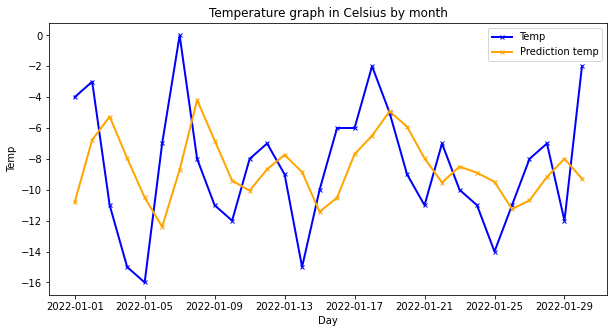

In [105]:
month, year = 1, 2022
df_result.reset_index(drop = False, inplace=True)
comparison(df_result, month, year)